In [1]:
import pickle
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from scipy.misc import imsave
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
# from pipeline_functions import *
# from process_frame import *
% matplotlib inline

# Get camera calibration matrix and distortion coefficients given a set of chessboard images

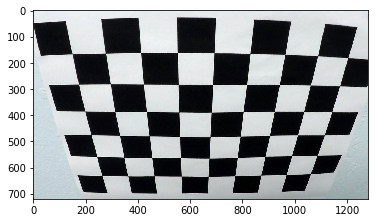

In [45]:
# example calibration image
c1 = cv2.imread('./camera_cal/calibration2.jpg')
plt.imshow(c1)

## [np.mgrid](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.mgrid.html)
## [glob.glob](https://docs.python.org/2/library/glob.html)

## [findChessboardCorners](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html?highlight=findchessboardcorners#cv2.findChessboardCorners)

## [drawChessboardCorners](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html?highlight=drawchessboardcorners#cv2.drawChessboardCorners)
```np.mgrid[0:9, 0:6].T.reshape([-1, 2]):```

```array([[0, 0], [1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [7, 0], [8, 0], [0, 1], [1, 1], [2, 1], ..., [8, 5]])```
      

In [6]:
def get_calibration_parameters(calibration_image_path, nx, ny):
    '''
    This function detect the parameters for camera calibration
    该方程意在检测出用于摄像头校正的corners位置的参数
    objectpoints中包含了一张没有变形的棋盘图片中corners应在的位置
    imagepoints代表检测出corners所在的位置
    '''
    # get image size
    img_size = cv2.imread(calibration_image_path[0]).shape[:2]
    # list to store object points and image points of all the images
    imagepoints = [] # 2d points in image plane 图像上检测出的corners坐标
    objectpoints = [] # 3d points in real world space 现实中的坐标

    # Creating object points like ([0, 0, 0], [5, 5, 0], ...)
    obj = np.zeros([nx*ny, 3], np.float32)
    obj[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape([-1, 2]) 

    for image_path in calibration_image_path:
        # read each image
        img = cv2.imread(image_path)
        
        # Convert image to gray scale 
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find chestboard coners
        # flags == None
        # ret: if this function detected corners or not
        ret, corners = cv2.findChessboardCorners(gray_img, (nx,ny), None) # corners includes all coordinates

        # if corners detected, add to objects points and image points
        if ret == True:
            objectpoints.append(obj)
            imagepoints.append(corners)

    #         img = cv2.drawChessboardCorners(c1, (9,6), corners, ret)
    #         plt.imshow(img)

    objectpoints = np.array(objectpoints)
    imagepoints = np.array(imagepoints)
    
    return objectpoints, imagepoints

## pipeline of camera calibration

In [12]:
# read pathes of all calibration images  
images = glob.glob('./camera_cal/calibration*.jpg')

# get calibration parameters
objectpoints, imagepoints = get_calibration_parameters(images, 9, 6)

In [ ]:
def cal_undistort(img, objectpoints, imagepoints):
    '''
    Use cv2.undistort() to calculate the calibration matrix 校正矩阵 and distortion coefficients 失真系数
    '''
    img_size = img.shape[:2]
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpoints, imagepoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

<br><br><br><br><br><br>

# Apply a distortion correction to raw images
## [cv2.calibrateCamera](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html?highlight=calibratecamera#cv2.calibrateCamera)
## [cv2.undistort](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html?highlight=undistort#cv2.undistort)

### Undistortion Test

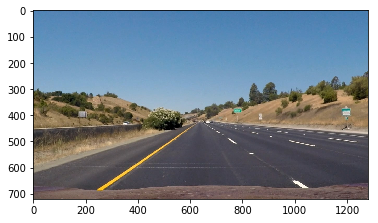

In [192]:
img = cv2.imread('./test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

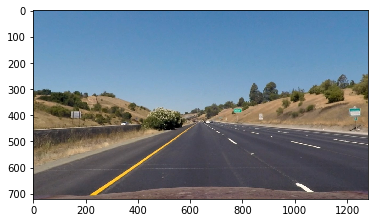

In [211]:
undis_img = cal_undistort(img, objectpoints, imagepoints)
plt.imshow(undis_img)

<br><br><br><br><br><br>

# Use color transforms, gradients, etc., to create a thresholded binary image

## Absolute Sobel Operator

In [125]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobel_x)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    uint8_sobelx = np.uint8(255 * abs_sobelx/np.max(abs_sobelx))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(uint8_sobelx)
    # 6) Return this mask as your binary_output image
    binary_output[(uint8_sobelx >= thresh_min) & (uint8_sobelx <= thresh_max)] = 1
    
    return binary_output

## Magnitude of Sobel Operator

In [126]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COL`OR_BGR2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    magnitude = np.absolute(np.square(sobel_x) + np.square(sobel_y))
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    uint8_mag = np.uint8(255 * magnitude/np.max(magnitude))
    
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(uint8_mag)
    
    # 6) Return this mask as your binary_output image
    binary_output[(uint8_mag >= mag_thresh[0]) & (uint8_mag <= mag_thresh[1])] = 1
    
    return binary_output

## Gradients direction

In [127]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobel_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobel_x)
    abs_sobely = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dires = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dires)
    # 6) Return this mask as your binary_output image
    binary_output[(dires >= thresh[0]) & (dires <= thresh[1])] = 1
    return binary_output

# HLS Selection

In [128]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(hls_img[:,:,2])
    # 3) Return a binary image of threshold result
    binary_output[(hls_img[:,:,2] > thresh[0]) & (hls_img[:,:,2] <= thresh[1])] = 1
    return binary_output

# Combined Selection Test

In [129]:
def select_combined_binary(undis_img):
    # Convert to HLS color space and make the HLS selection
    HLS_selected = hls_select(undis_img, thresh=(90, 255))

    # Gradients direction selection
    Gradient_direction_selected = dir_threshold(undis_img, sobel_kernel=9, thresh=(0.7, 1.3))

    # Magnitude of Sobel operator
    Mag_sobel_selected = mag_thresh(undis_img, sobel_kernel=9, mag_thresh=(90, 250))


    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( HLS_selected, Gradient_direction_selected, Mag_sobel_selected )) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(HLS_selected)
    combined_binary[(HLS_selected == 1) | (Gradient_direction_selected == 1) & (Mag_sobel_selected == 1)] = 1

    return combined_binary

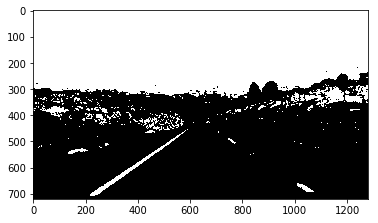

In [437]:
img = cv2.imread('./test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undis_img = cal_undistort(img, objectpoints, imagepoints)
plt.imshow(select_combined_binary(undis_img), cmap='gray')

<br><br><br><br><br><br>

# Apply a perspective transform to rectify binary image 
## [cv2.warpPerspective](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html?highlight=getperspectivetransform#cv2.getPerspectiveTransform)

## [cv2.warpPerspective](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html?highlight=warpperspective#cv2.warpPerspective)

In [130]:
def corners_unwarp(undistorted_gray_img, src, dst):
    '''
    src: source points ( np.float32([[,],[,],[,],[,]]) )
    dst: destination points ( np.float32([[,],[,],[,],[,]]) )
    '''
    # 1) get image size 
    img_size = (undistorted_gray_img.shape[1], undistorted_gray_img.shape[0])

#     offset = 100 # offset for dst points
    
#     dst = np.float32([[offset,offset],[img_size[0],offset],
#                       [img_size[0]-offset, img_size[1]-offset], 
#                       [offset, img_size[1]-offset]])

    # 2) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # 3) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undistorted_gray_img, M, img_size, flags=cv2.INTER_LINEAR)
    
    # 4) inverse PerspectiveTransform
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return warped, M, Minv

### Test perspective transformation

In [116]:
img = cv2.imread('./test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undis_img = cal_undistort(img, objectpoints, imagepoints)
combined_binary = select_combined_binary(undis_img)

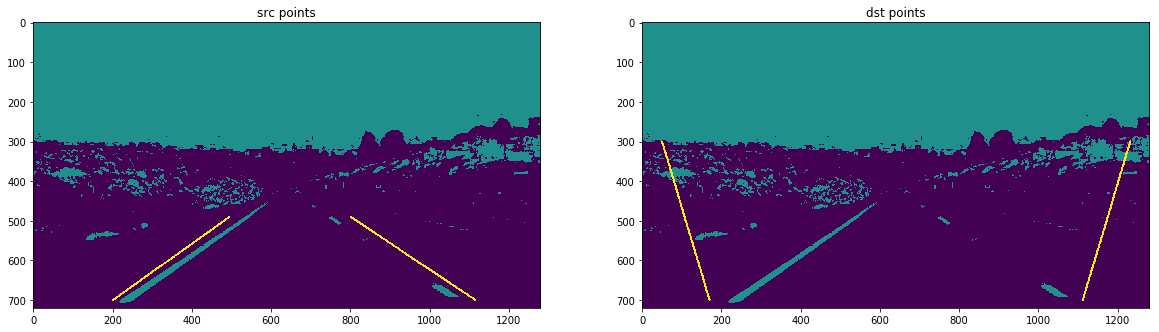

In [145]:
img_size = (combined_binary.shape[1], combined_binary.shape[0])
# src = np.float32([[555,460],[195,700],[730,460],[1115,700]])
# dst = np.float32([[20,250],[170,700],[1260,250],[1110,700]])

src = np.float32([[495,490],[200,700],[800,490],[1115,700]])
dst = np.float32([[50,300],[170,700],[1230,300],[1110,700]])

# offset = 100 # offset for dst points
    
# dst = np.float32([[offset,offset],[offset, img_size[1]-offset],
#                       [img_size[0]-offset, img_size[1]-offset], [img_size[0],offset]
#                       ])



src_undis_img = np.copy(combined_binary)
cv2.line(src_undis_img, (src[0,0], src[0,1]), (src[1,0], src[1,1]), [2, 2, 2], 3)
cv2.line(src_undis_img, (src[2,0], src[2,1]), (src[3,0], src[3,1]), [2, 2, 2], 3)

dst_undis_img = np.copy(combined_binary)
cv2.line(dst_undis_img, (dst[0,0], dst[0,1]), (dst[1,0], dst[1,1]), [2, 2, 2], 3)
cv2.line(dst_undis_img, (dst[2,0], dst[2,1]), (dst[3,0], dst[3,1]), [2, 2, 2], 3)

# Plotting src, dst points
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('src points')
ax1.imshow(src_undis_img)

ax2.set_title('dst points')
ax2.imshow(dst_undis_img)

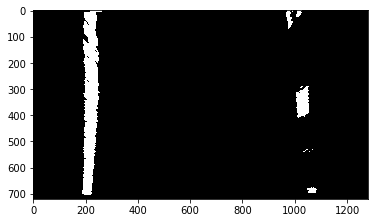

In [146]:
# perspective transfermation 
warped, M, Minv = corners_unwarp(combined_binary, src, dst)
image_size = (combined_binary.shape[1], combined_binary.shape[0])
plt.imshow(warped, cmap='gray')

# Detect lane pixels and fit to find the lane boundary

## [cv2.rectangle](https://docs.opencv.org/2.4/modules/core/doc/drawing_functions.html?highlight=rectangle#cv2.rectangle)

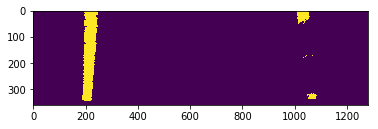

In [136]:
plt.imshow(warped[warped.shape[0]//2:,:])

In [132]:
def sliding_window_search( warped ):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    # 首先随便找两个整个图中按列求和最大的点
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    # all nonzero pixels inside current frame 该帧所有的非零点的坐标
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    # 把之前找的初始车道线的点赋给存储新车道线坐标的变量
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    # 设定一个探测到的非零点pixel数目的最小判定数，若大于此数则认定为就是车道线
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    # 用来存储左右框框里圈到的所有可能是车道线的点的坐标
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    # 从图的最下面往上搜索
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height

        # confirm the X indice of left line
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        # confirm the X indice of right line
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        # 在图上画框框
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) # position 1, position 2, color, thickness
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window
        # ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        # (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)) ======>
        #                                     array([ True, False, False, False, False,  True, False, ...], dtype=bool)

        # 返回非框框内的非零点的X坐标
        nonzero_left_idxs = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

        nonzero_right_idxs = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        # 把这些检测到的框框内所有非零点的x坐标添加到一个序列里面
        left_lane_inds.append(nonzero_left_idxs)
        right_lane_inds.append(nonzero_right_idxs)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(nonzero_left_idxs) > minpix:
        # 如果框框内检测到的非零点有大于我们设的门槛数值，则计算出一个平均值作为新的车道线的X坐标，并更新给车道线坐标变量
            leftx_current = np.int(np.mean(nonzerox[nonzero_left_idxs]))
        if len(nonzero_right_idxs) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[nonzero_right_idxs]))

    # Concatenate the arrays of indices
    # 添加新的非零点进来，会从第一个小方块开始累加起来，用来fit出一个二次函数表示这条车道线
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    # fit出左右各一条二次函数来表示左右车道线
#     left_fit = np.polyfit(lefty, leftx, 2)
#     right_fit = np.polyfit(righty, rightx, 2)

# # visualization
# # Generate x and y values for plotting
# ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
# out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
# plt.imshow(out_img)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)
    return leftx, lefty, rightx, righty, leftx_current, rightx_current, left_lane_inds, right_lane_inds



def calculate_curvature(undis_img, warped, leftx, rightx, lefty, righty, left_lane_inds, right_lane_inds):
    
    ##################### draw lines and area #######################

    # fit出左右各一条二次函数来表示左右车道线
    margin = 15
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    window_img = np.zeros_like(color_warp)
    
    
    # Color in left and right line pixels
    window_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    window_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,0, 255))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,0, 255))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp_1 = cv2.warpPerspective(color_warp, Minv, image_size) 
    newwarp_2 = cv2.warpPerspective(window_img, Minv, image_size) 
    
    # Combine the result with the original image
    color_line = cv2.addWeighted(newwarp_1, 1, newwarp_2, 1, 0)
    result = cv2.addWeighted(undis_img, 1, color_line, 0.3, 0)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    
    
    
#     # Color in left and right line pixels
#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    
    ###################### Calculate the curvature #####################
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    return result, left_curverad, right_curverad

# Test with test images

In [137]:
def lane_line_detect(img, objectpoints, imagepoints, src, dst):
    undis_img = cal_undistort(img, objectpoints, imagepoints)

    combined_binary = select_combined_binary(undis_img)
    
    warped, M, Minv = corners_unwarp(combined_binary, src, dst)
    
    image_size = (combined_binary.shape[1], combined_binary.shape[0])
    
    #Minv = cv2.getPerspectiveTransform(dst, src)

    leftx, lefty, rightx, righty, leftx_current, rightx_current, left_lane_inds, right_lane_inds = sliding_window_search(warped)
    
    result, left_curverad, right_curverad = calculate_curvature(undis_img, warped, leftx, rightx, lefty, righty, left_lane_inds, right_lane_inds)
    
    return result, left_curverad, right_curverad

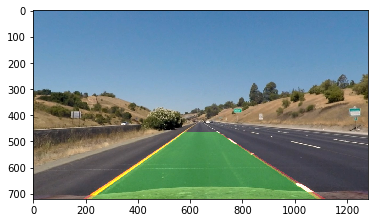

left radius 2162.70442711 right radius 5400.98395653


/Users/congcong/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


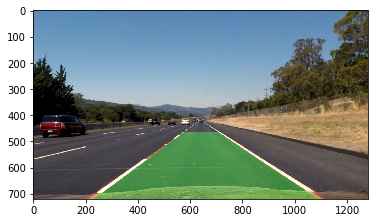

left radius 1068.63335882 right radius 20969.9063


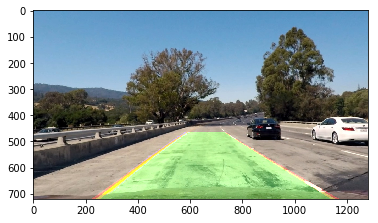

left radius 1146.92240576 right radius 1799.19169502


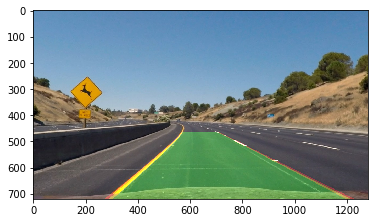

left radius 641.920721645 right radius 17594.6111944


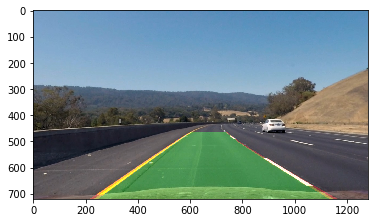

left radius 1628.91470257 right radius 453.238028615


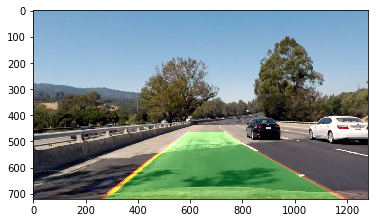

left radius 1040.80532263 right radius 652.033115259


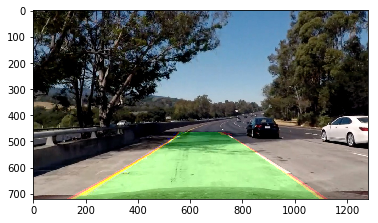

left radius 281.131582717 right radius 427.601505365


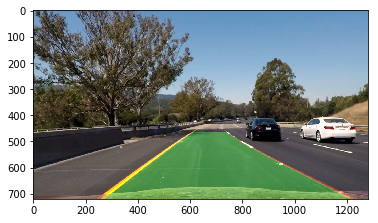

left radius 858.632494636 right radius 419.564753899


In [147]:
########### read all test images ############

test_img_folder = './test_images'
test_img_list = []
for each_img in os.listdir(test_img_folder):
    test_img_list.append(cv2.imread(os.path.join(test_img_folder, each_img)))
test_img_list = np.array(test_img_list)

########## set source, destination points ###########
# src = np.float32([[530,480],[200,700],[750,480],[1105,700]])
# dst = np.float32([[80,200],[140,700],[1200,200],[1140,700]])

# src = np.float32([[555,460],[195,700],[730,460],[1115,700]])
# dst = np.float32([[20,250],[170,700],[1260,250],[1110,700]])


for ii, (test_img, img_name) in enumerate(zip(test_img_list, os.listdir(test_img_folder))):
    result, left_curverad, right_curverad = lane_line_detect(test_img, objectpoints, imagepoints, src, dst)
    plt.imshow(result)
    plt.show()
    print('left radius', left_curverad, 'right radius', right_curverad)
    imsave('./output_images/{}'.format(img_name), result)

<br><br><br><br><br><br><br>

# From now, let's test on videos
## [np.argsort](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.argsort.html)
## [np.append](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.append.html)

In [2]:
class Line:
    def __init__(self, side):
        self.side = side
        # Was the line found in the previous frame?
        self.found = False

        # Remember x and y values of lanes in previous frame
        self.X = None
        self.Y = None

        # Store recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)

        # Remember previous x intercept to compare against current one
        self.lastx_int = None
        self.last_top = None

        # Remember radius of curvature
        self.radius = None

        # Store recent polynomial coefficients for averaging across frames
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []

        # Count the number of frames
        self.count = 0



    def sliding_window_search(self, warped):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        if self.found == False:
            histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

            # Create an output image to draw on and  visualize the result
            # out_img = np.dstack((warped, warped, warped))*255

            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]//2)
            # 首先随便找两个整个图中按列求和最大的点
            if self.side == 'left':
                x_base = np.argmax(histogram[:midpoint])
            else:
                x_base = np.argmax(histogram[midpoint:]) + midpoint

            # Choose the number of sliding windows
            nwindows = 9
            # Set height of windows
            window_height = np.int(warped.shape[0]/nwindows)
            # Identify the x and y positions of all nonzero pixels in the image
            # all nonzero pixels inside current frame 该帧所有的非零点的坐标
            nonzero = warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Current positions to be updated for each window
            # 把之前找的初始车道线的点赋给存储新车道线坐标的变量
            x_current = x_base
            
            # Set the width of the windows +/- margin
            margin = 100
            # Set minimum number of pixels found to recenter window
            # 设定一个探测到的非零点pixel数目的最小判定数，若大于此数则认定为就是车道线
            minpix = 50
            # Create empty lists to receive left and right lane pixel indices
            # 用来存储左右框框里圈到的所有可能是车道线的点的坐标
            lane_line_inds = []

            # Step through the windows one by one
            # 从图的最下面往上搜索
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = warped.shape[0] - (window+1)*window_height
                win_y_high = warped.shape[0] - window*window_height

                # confirm the X indice of line
                win_x_low = x_current - margin
                win_x_high = x_current + margin

                # Identify the nonzero pixels in x and y within the window
                # ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                # (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)) ======>
                # array([ True, False, False, False, False,  True, False, ...], dtype=bool)

                # 返回非框框内的非零点的X坐标
                nonzero_idxs = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                  (nonzerox >= win_x_low) &  (nonzerox < win_x_high)).nonzero()[0]

                # Append these indices to the lists
                # 把这些检测到的框框内所有非零点的x坐标添加到一个序列里面
                lane_line_inds.append(nonzero_idxs)
                
                # If you found > minpix pixels, recenter next window on their mean position
                if len(nonzero_idxs) > minpix:
                # 如果框框内检测到的非零点有大于我们设的门槛数值，则计算出一个平均值作为新的车道线的X坐标，并更新给车道线坐标变量
                    x_current = np.int(np.mean(nonzerox[nonzero_idxs]))


            # Concatenate the arrays of indices
            # 添加新的非零点进来，会从第一个小方块开始累加起来，用来fit出一个二次函数表示这条车道线
            lane_line_inds = np.concatenate(lane_line_inds)
            
            # Extract line pixel positions
            x_pos = nonzerox[lane_line_inds]
            y_pos = nonzeroy[lane_line_inds] 

            if np.sum(x_pos) > 0:
                self.found = True
            else:
                y_pos = self.Y
                x_pos = self.X
        # Fit a second order polynomial to each
        # fit出左右各一条二次函数来表示左右车道线
            # left_fit = np.polyfit(lefty, leftx, 2)
            # right_fit = np.polyfit(righty, rightx, 2)

        return np.array(x_pos), np.array(y_pos), nonzerox, nonzeroy, self.found

    def found_based_search(self, wraped, margin=50):
        """
        this search is based on previous found, if you already found lines on previous frame,         
        it's not necessary to make slide windows search against.
        """
        if self.found == True:
            nonzero = wraped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])

            lane_line_inds = ((nonzerox > (np.mean(self.fit0)*(nonzeroy**2) + np.mean(self.fit1)*nonzeroy + np.mean(self.fit2) - margin)) & (nonzerox < (np.mean(self.fit0)*(nonzeroy**2) + np.mean(self.fit1)*nonzeroy + np.mean(self.fit2) + margin)))
            lane_line_inds = np.array(lane_line_inds)
            # Again, extract line pixel positions
            x_pos = nonzerox[lane_line_inds]
            y_pos = nonzeroy[lane_line_inds]

        if np.sum(x_pos) == 0:
            self.found = False
        return np.array(x_pos), np.array(y_pos), nonzerox, nonzeroy, self.found




    def calculate_curvature_radius(self, x_pos, y_pos):

        '''
        this function is used to calculate curvature in meters
        '''
        # set evaluate point
        y_eval = np.max(y_pos)

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(y_pos*ym_per_pix, x_pos*xm_per_pix, 2)

        # Calculate the new radii of curvature
        curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

        return curverad



    def calculate_intercept(self, poly, img_y):
        '''
        calculate the x values of fitted polynomial using bottom and top position inside a frame
        '''
        bottom_x = poly[0] * img_y ** 2 + poly[1] * img_y + poly[2]

        top_x = poly[0] * 0 ** 2 + poly[1] * 0 + poly[2]

        return bottom_x, top_x


    def x_y_pos_sorted(self, x_pos, y_pos):
        '''
        sorted the detected x and y positions in order
        按从小到大排序
        '''
        # np.argsort 给出从小到大排序的idxs
        sorted_idx = np.argsort(y_pos)
        sorted_y_pos = y_pos[sorted_idx]
        sorted_x_pos = x_pos[sorted_idx]
                                                         
        return sorted_x_pos, sorted_y_pos

In [3]:
def video_abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobel_x)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    uint8_sobelx = np.uint8(255 * abs_sobelx/np.max(abs_sobelx))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(uint8_sobelx)
    # 6) Return this mask as your binary_output image
    binary_output[(uint8_sobelx >= thresh_min) & (uint8_sobelx <= thresh_max)] = 1

    return binary_output



def video_mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Calculate the magnitude 
    magnitude = np.absolute(np.square(sobel_x) + np.square(sobel_y))

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    uint8_mag = np.uint8(255 * magnitude/np.max(magnitude))

    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(uint8_mag)

    # 6) Return this mask as your binary_output image
    binary_output[(uint8_mag >= mag_thresh[0]) & (uint8_mag <= mag_thresh[1])] = 1

    return binary_output


def video_dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobel_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
        # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobel_x)
    abs_sobely = np.absolute(sobel_y)
        # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dires = np.arctan2(abs_sobely, abs_sobelx)
        # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dires)
        # 6) Return this mask as your binary_output image
    binary_output[(dires >= thresh[0]) & (dires <= thresh[1])] = 1
    return binary_output



def video_hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(hls_img[:,:,2])
        # 3) Return a binary image of threshold result
    binary_output[(hls_img[:,:,2] > thresh[0]) & (hls_img[:,:,2] <= thresh[1])] = 1
    return binary_output


def video_select_combined_binary(undis_img):
    # Convert to HLS color space and make the HLS selection
    HLS_selected = video_hls_select(undis_img, thresh=(90, 255))

    # Gradients direction selection
    Gradient_direction_selected = video_dir_threshold(undis_img, sobel_kernel=9, thresh=(0.7, 1.3))

    # Magnitude of Sobel operator
    Mag_sobel_selected = video_mag_thresh(undis_img, sobel_kernel=9, mag_thresh=(90, 250))


    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( HLS_selected, Gradient_direction_selected, Mag_sobel_selected )) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(HLS_selected)
    combined_binary[(HLS_selected == 1) | (Gradient_direction_selected == 1) & (Mag_sobel_selected == 1)] = 1

    return combined_binary



def corners_unwarp(undistorted_gray_img, src, dst):
    '''
    src: source points ( np.float32([[,],[,],[,],[,]]) )        
    dst: destination points ( np.float32([[,],[,],[,],[,]]) )
    '''
    # 1) Convert to grayscale
    img_size = (undistorted_gray_img.shape[1], undistorted_gray_img.shape[0])
            # offset = 100 # offset for dst points

            # dst = np.float32([[offset,offset],[img_size[0],offset],
            #   [img_size[0]-offset, img_size[1]-offset], 
            #   [offset, img_size[1]-offset]])

    # 2) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # 3) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undistorted_gray_img, M, img_size, flags=cv2.INTER_LINEAR)

    # 4) inverse PerspectiveTransform
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped, M, Minv

In [7]:
def draw_lines(warped, undis_img, img_size, nonzerox, nonzeroy, left_fit, right_fit, leftx_pos, rightx_pos, Minv, margin=15):
    # Draw lines 
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    window_img = np.zeros_like(color_warp)
    
    # Color in left and right line pixels
    window_img[nonzeroy[np.int_(leftx_pos)], nonzerox[np.int_(leftx_pos)]] = [255, 0, 0]
    window_img[nonzeroy[np.int_(rightx_pos)], nonzerox[np.int_(rightx_pos)]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
      ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
      ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,0, 255))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,0, 255))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp_1 = cv2.warpPerspective(color_warp, Minv, img_size) 
    newwarp_2 = cv2.warpPerspective(window_img, Minv, img_size) 
    
    # Combine the result with the original image
    color_line = cv2.addWeighted(newwarp_1, 1, newwarp_2, 1, 0)
    result = cv2.addWeighted(undis_img, 1, color_line, 0.3, 0)
    # result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)a

    return result


def process_frames(img):
    # get image size
    img_size = (img.shape[1], img.shape[0])
    
    # undistort image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpoints, imagepoints, (img_size[1], img_size[0]), None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    # binary select 
    combined_binary = video_select_combined_binary(undist)

    # warp image
    warped, M, Minv = corners_unwarp(combined_binary, src, dst)

    if Left.found == True: 
        leftx_pos, lefty_pos, nonzerox, nonzeroy, Left.found = Left.found_based_search(warped, margin=50)

    if Left.found == False: 
        leftx_pos, lefty_pos, nonzerox, nonzeroy, Left.found = Left.sliding_window_search(warped)

    if Right.found == True: 
        rightx_pos, righty_pos, nonzerox, nonzeroy, Right.found = Right.found_based_search(warped, margin=50)

    if Right.found == False: 
        rightx_pos, righty_pos, nonzerox, nonzeroy, Right.found = Right.sliding_window_search(warped)

    # Calculate polynomial fit based on points
    left_fit = np.polyfit(lefty_pos, leftx_pos, 2)
    right_fit = np.polyfit(righty_pos, rightx_pos, 2)

    # Calculate intercepts of top and bottom position
    left_bott, left_top = Left.calculate_intercept(left_fit, img_size[1])
    right_bott, right_top = Right.calculate_intercept(right_fit, img_size[1])

    # Store recent intercepts and average them
    Left.x_int.append(left_bott)
    Left.top.append(left_top)
    Right.x_int.append(right_bott)
    Right.top.append(right_top)
    # average and update
    left_bott = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    right_bott = np.mean(Right.x_int)
    right_top = np.mean(Right.top)
    # update to last intercepts
    Left.lastx_int = left_bott
    Left.last_top = left_top
    Right.lastx_int = right_bott
    Right.last_top = right_top

    # Add updated intercepts to x and y points
    leftx_pos = np.append(leftx_pos, left_bott)
    lefty_pos = np.append(lefty_pos, img_size[1])
    leftx_pos = np.append(leftx_pos, left_top)
    lefty_pos = np.append(lefty_pos, 0)

    rightx_pos = np.append(rightx_pos, right_bott)
    righty_pos = np.append(righty_pos, img_size[1])
    rightx_pos = np.append(rightx_pos, right_top)
    righty_pos = np.append(righty_pos, 0)

    # sort points in order
    leftx_pos, lefty_pos = Left.x_y_pos_sorted(leftx_pos, lefty_pos)
    rightx_pos, righty_pos = Right.x_y_pos_sorted(rightx_pos, righty_pos)

    # Save detected lane line points in previous frame
    Left.X = leftx_pos
    Left.Y = lefty_pos
    Right.X = rightx_pos
    Right.Y = righty_pos

    # Now calculate the polynomial again and store it to recent polynomial coefficients
    left_fit = np.polyfit(lefty_pos, leftx_pos, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), np.mean(Left.fit1), np.mean(Left.fit2)]

    right_fit = np.polyfit(righty_pos, rightx_pos, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]


    # Calculate the x values in fitted polynomial of corresponidng y value
    left_fitx = left_fit[0] * lefty_pos ** 2 + left_fit[1] * lefty_pos + left_fit[2]
    Left.fitx = left_fitx
    right_fitx = right_fit[0] * righty_pos ** 2 + right_fit[1] * righty_pos + right_fit[2]
    Right.fitx = right_fitx

    # Calculate radius of curvature in meters
    left_curverad = Left.calculate_curvature_radius(leftx_pos, lefty_pos)
    right_curverad = Right.calculate_curvature_radius(rightx_pos, righty_pos)

    # Store curvature to class every 2 frames
    if Left.count % 2 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad

    # Calculate the car position
    car_pos = (left_bott + right_bott) / 2
    bias_from_center = abs(car_pos - img_size[0]/2) * 3.7 / 700 # in meters

    # Draw detected lines on every frame
    result = draw_lines(warped, undist, img_size, nonzerox, nonzeroy, left_fit, right_fit, leftx_pos, rightx_pos, Minv, margin=15)


    # Print the car_pos and radius of curvature 
    if car_pos > img_size[0]/2:
        cv2.putText(result, 'The Vehicle is {:.2f}m left of center'.format(bias_from_center), (100, 80),
            fontFace=16, fontScale=2, color=(255, 255, 255), thickness=2)
    else:
        cv2.putText(result, 'The Vehicle is {:.2f}m right of center'.format(bias_from_center), (100, 80),
            fontFace=16, fontScale=2, color=(255, 255, 255), thickness=2)

    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {}(ms)'.format(int((Left.radius + Right.radius) / 2)), (140, 160),
        fontFace=16, fontScale=2, color=(255, 255, 255), thickness=2)

    Left.count += 1

    return result

In [8]:
src = np.float32([[495,490],[200,700],[800,490],[1115,700]])
dst = np.float32([[50,300],[170,700],[1230,300],[1110,700]])

# read pathes of all calibration images  
images = glob.glob('./camera_cal/calibration*.jpg')

# get calibration parameters
objectpoints, imagepoints = get_calibration_parameters(images, 9, 6)

# Test on project video

In [9]:
# !mkdir test_videos_output
# define class
Left = Line("left")
Right = Line("right")

video_output = './test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
project_video = VideoFileClip("./project_video.mp4")
processed_video = project_video.fl_image(process_frames) #NOTE: this function expects color images!!
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./test_videos_output/project_video.mp4
[MoviePy] Writing video ./test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [40:00<00:01,  1.91s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos_output/project_video.mp4 

CPU times: user 39min 12s, sys: 1min 36s, total: 40min 49s
Wall time: 40min 1s
